In [4]:
import uproot4
import numpy as np
import numba
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData_ap(fname="", treeName="Truth"):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        }),
                       }, depth_limit=1)
    return dq_events


######## READ EVENTS
filename_ap = "/data/t3home000/dhoang/DQ/outfiles/ApMuons_May262021_10k.root"
dq_events_ap = getData_ap(filename_ap)


def getData_dy(fname="", treeName="Truth"):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        }),
                        "reco_dimuon": ak.zip({
                                            "mass": dq_dict_ak1["dimuon_mass"],
                                            "x": dq_dict_ak1["dimuon_x_vtx"],
                                            "y": dq_dict_ak1["dimuon_y_vtx"],
                                            "z": dq_dict_ak1["dimuon_z_vtx"],
                                            "n_px": dq_dict_ak1["dimuon_nmom_x"],
                                            "n_py": dq_dict_ak1["dimuon_nmom_y"],
                                            "n_pz": dq_dict_ak1["dimuon_nmom_z"],
                                            "p_px": dq_dict_ak1["dimuon_pmom_x"],
                                            "p_py": dq_dict_ak1["dimuon_pmom_y"],
                                            "p_pz": dq_dict_ak1["dimuon_pmom_z"],
                                            "chisq": dq_dict_ak1["dimuon_chisq"],
                            
                        }),
                        "truth_dimuon":ak.zip({
                                            "mass": dq_dict_ak1['truthdimuon_mass'],
                                            "x": dq_dict_ak1['truthdimuon_x_vtx'],
                                            "y": dq_dict_ak1['truthdimuon_y_vtx'],
                                            "z": dq_dict_ak1['truthdimuon_z_vtx'],
                                            "px": dq_dict_ak1['truthdimuon_px'],
                                            "py": dq_dict_ak1['truthdimuon_py'],
                                            "pz": dq_dict_ak1['truthdimuon_pz'],
                            
                        })
                       }, depth_limit=1)
    return dq_events

######## READ EVENTS
filename_dy = "/data/t3home000/dhoang/DQ/outfiles/DY_Jun1621_100k.root"
dq_events_dy = getData_dy(filename_dy, treeName = 'Events')

Saving plots to:  plot/28-06-2021


## DY dimuon resolution plot

In [2]:
def dimuon_resolution_ap(dq_events):
    
    #"Reco" momentum
    reco_dimuon_px = ak.sum(dq_events["Track_St1"].px, 1)
    reco_dimuon_py = ak.sum(dq_events["Track_St1"].py, 1)
    reco_dimuon_pz = ak.sum(dq_events["Track_St1"].pz, 1)
    
    truth_dimuon_px = ak.sum(dq_events["GenVertex"].px, 1)
    truth_dimuon_py = ak.sum(dq_events["GenVertex"].py, 1)
    truth_dimuon_pz = ak.sum(dq_events["GenVertex"].pz, 1)
    
    reco_dimuon_p = np.sqrt(reco_dimuon_px**2 + reco_dimuon_py**2 + reco_dimuon_pz**2)
    truth_dimuon_p = np.sqrt(truth_dimuon_px**2 + truth_dimuon_py**2 + truth_dimuon_pz**2)
    
    #Select the events that are reconstructed
    reco_selection = dq_events["nTrack"].n_tracks == 2
    
    reco_p = np.asarray(reco_dimuon_p[reco_selection])
    truth_p = np.asarray(truth_dimuon_p[reco_selection])
    
    print(sum(reco_selection))
    
    p_resolution = [] #To save the resolution (sigma) of the fit
    p_average = []
    p_ranges = []
    p_err = []
    
    #Specify the ranges to calculate the resolution in 
    for i in [6,7,8,9,10]:
        
        hist_range = [-4,4]
        
        p_range = 10
        p_min = i*p_range #GeV
        p_max = (i+1)*p_range
        p_ranges.append([p_min,p_max]) #Save for resolution later
        
        print("Truth momentum range: {},{} GeV".format(p_min, p_max))
        
        local_selection = (truth_p > p_min) & (truth_p < p_max)
        p_average.append(np.mean(truth_p[local_selection]))
        
        p_residual = copy.deepcopy(reco_p[local_selection] - truth_p[local_selection])
        
        if p_residual.size != 0:
        
            #Initial distribution and labelling
#             plt.hist(p_residual,
#                      bins = 50,
#                      range = hist_range,
#                      density = True)
#             plt.plot([],[], 'none', label="Truth p: {}-{} GeV".format(p_min, p_max))

            ## Gaussian fit
            ## Fit directly on the histogram
            def fit_function(x, A, mu, sig):
                return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

            bins = np.linspace(hist_range[0], hist_range[1], 51)
            binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
            data_entries, _ = np.histogram(p_residual, bins=bins,
                                           range = hist_range, density = True)

            mask = data_entries!=0
            #Fit the function to the histogram data.
            popt, pcov = curve_fit(fit_function,
                                   xdata=binscenters[mask],
                                   ydata=data_entries[mask],
                                   sigma = np.sqrt(data_entries[mask]),
                                   absolute_sigma = False,
                                   p0=[1, 0, 0.5])

            #Error for parameter estimations
            perr = np.sqrt(np.diag(pcov))
            print("Error for parameter esimations: ", perr)
            p_err.append(perr[2])

            std_fit = np.abs(popt[2])
            mean_fit = popt[1]
            res_fit = std_fit/mean_fit
            sigma_res = perr[2]/mean_fit
            print("Standard deviation (fit) is", std_fit)
            print("Mean (fit) is", mean_fit)
            print("Resolution (fit) is {}".format(res_fit))
            p_resolution.append(std_fit)

            #Plot fitted gaussian
#             plt.plot(bins,
#                      fit_function(bins, *popt),
#                      "r-",
#                      linewidth=4,
#                      label='Best fit')

#             plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
#             plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%popt[2])

            #Label the axes
#             plt.xlabel(r'Reco $p_z$ - Truth $p_z$ (GeV)')
#             plt.ylabel('Normalized counts')

#             plt.legend()
#             plt.show()

        
    #MAIN PLOT
    #Plot momentum average
    #plt.scatter(p_average, p_resolution, s=180, c='#2ca02c', label = "Average p [GeV]", zorder = 10)
    
    #Plot the resolution based on momentum range. 
    plt.scatter(p_average,
               [x/y*100 for x, y in zip(p_resolution, p_average)],
                s = 180,
                label = r"$A'\rightarrow \mu^{+} \mu^{-}$ (displaced)")

    #Plot the error bars
    plt.errorbar(p_average,
                [x/y*100 for x, y in zip(p_resolution, p_average)],
                yerr=[x/y*100 for x, y in zip(p_err, p_average)],
                fmt='none',
                elinewidth=3,
                capsize=8)

In [3]:
def dimuon_resolution_dy(dq_events):
    
    #dimuon momentum
    reco_dimuon_px = dq_events["reco_dimuon"].n_px + dq_events["reco_dimuon"].p_px
    reco_dimuon_py = dq_events["reco_dimuon"].n_py + dq_events["reco_dimuon"].p_py
    reco_dimuon_pz = dq_events["reco_dimuon"].n_pz + dq_events["reco_dimuon"].p_pz
    
    reco_dimuon_p = np.sqrt(reco_dimuon_px**2 + reco_dimuon_py**2 + reco_dimuon_pz**2)
    truth_dimuon_p = np.sqrt(dq_events["truth_dimuon"].px**2 +\
                             dq_events["truth_dimuon"].py**2 +\
                             dq_events["truth_dimuon"].pz**2)
    
    #Select the events that are reconstructed
    reco_selection = ak.any(dq_events["reco_dimuon"].mass, axis = 1) &\
                     (ak.num(dq_events["truth_dimuon"].mass) < 2) #Remove those with 4 truth muons
    
    
    reco_p = np.asarray(reco_dimuon_p[reco_selection])
    truth_p = np.asarray(truth_dimuon_p[reco_selection])
    
    print(sum(reco_selection))
    
    p_resolution = [] #To save the resolution (sigma) of the fit
    p_average = []
    p_ranges = []
    p_err = []
    
    #Specify the ranges to calculate the resolution in 
    for i in [6,7,8,9,10]:
        
        hist_range = [-20,20]
        
        p_range = 10
        p_min = i*p_range #GeV
        p_max = (i+1)*p_range
        p_ranges.append([p_min,p_max]) #Save for resolution later
        
        print("Truth momentum range: {},{} GeV".format(p_min, p_max))
        
        local_selection = (truth_p > p_min) & (truth_p < p_max)
        p_average.append(np.mean(truth_p[local_selection]))
        
        p_residual = copy.deepcopy(reco_p[local_selection] - truth_p[local_selection])
        
        if p_residual.size != 0:
        
            #Initial distribution and labelling
#             plt.hist(p_residual,
#                      bins = 50,
#                      range = hist_range,
#                      density = True)
#             plt.plot([],[], 'none', label="Truth p: {}-{} GeV".format(p_min, p_max))

            ## Gaussian fit
            ## Fit directly on the histogram
            def fit_function(x, A, mu, sig):
                return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

            bins = np.linspace(hist_range[0], hist_range[1], 51)
            binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
            data_entries, _ = np.histogram(p_residual, bins=bins,
                                           range = hist_range, density = True)

            mask = data_entries!=0
            #Fit the function to the histogram data.
            popt, pcov = curve_fit(fit_function,
                                   xdata=binscenters[mask],
                                   ydata=data_entries[mask],
                                   sigma = np.sqrt(data_entries[mask]),
                                   absolute_sigma = False,
                                   p0=[1, 0, 0.5])

            #Error for parameter estimations
            perr = np.sqrt(np.diag(pcov))
            print("Error for parameter esimations: ", perr)
            p_err.append(perr[2])

            std_fit = np.abs(popt[2])
            mean_fit = popt[1]
            res_fit = std_fit/mean_fit
            sigma_res = perr[2]/mean_fit
            print("Standard deviation (fit) is", std_fit)
            print("Mean (fit) is", mean_fit)
            print("Resolution (fit) is {}".format(res_fit))
            p_resolution.append(std_fit)

            #Plot fitted gaussian
#             plt.plot(bins,
#                      fit_function(bins, *popt),
#                      "r-",
#                      linewidth=4,
#                      label='Best fit')

#             plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
#             plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%popt[2])

            #Label the axes
#             plt.xlabel(r'Reco $p_z$ - Truth $p_z$ (GeV)')
#             plt.ylabel('Normalized counts')

#             plt.legend()
#             plt.show()

        
    #MAIN PLOT
    #Plot momentum average
    #plt.scatter(p_average, p_resolution, s=180, c='#2ca02c', label = "Average p [GeV]", zorder = 10)
    
    #Plot the resolution based on momentum range. 
    plt.scatter(p_average,
               [x/y*100 for x, y in zip(p_resolution, p_average)],
                s = 180,
                label = "Drell-Yan (non-displaced)")

    #Plot the error bars
    plt.errorbar(p_average,
                [x/y*100 for x, y in zip(p_resolution, p_average)],
                yerr=[x/y*100 for x, y in zip(p_err, p_average)],
                fmt='none',
                elinewidth=3,
                capsize=8) 

## Overlapping plots

1886
Truth momentum range: 60,70 GeV
Error for parameter esimations:  [0.07008859 0.04878036 0.03867168]
Standard deviation (fit) is 0.5433649854707082
Mean (fit) is -0.002245209787231649
Resolution (fit) is -242.01078605695864
Truth momentum range: 70,80 GeV
Error for parameter esimations:  [0.03680795 0.03395035 0.02557705]
Standard deviation (fit) is 0.6484709479442684
Mean (fit) is 0.01975494204395472
Resolution (fit) is 32.82575805595488
Truth momentum range: 80,90 GeV
Error for parameter esimations:  [0.04435691 0.04306568 0.03337001]
Standard deviation (fit) is 0.6578927920524925
Mean (fit) is -0.0502454955927102
Resolution (fit) is -13.093567578382926
Truth momentum range: 90,100 GeV
Error for parameter esimations:  [0.03235616 0.04249214 0.0342671 ]
Standard deviation (fit) is 0.7744248974400262
Mean (fit) is 0.03725791848872696
Resolution (fit) is 20.78551161343976
Truth momentum range: 100,110 GeV
Error for parameter esimations:  [0.02206213 0.0406724  0.03111624]
Standard d

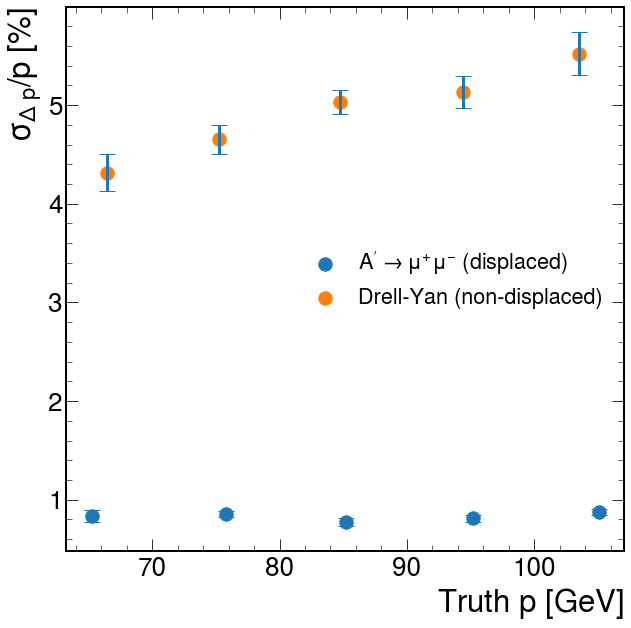

In [4]:
dimuon_resolution_ap(dq_events_ap)
dimuon_resolution_dy(dq_events_dy)

plt.xlabel(r'Truth $p$ [GeV]')
plt.ylabel(r'$\sigma_{\Delta~p}/p$ [%]')

plt.legend()
plt.show()